In [1]:
using Cxx
using PyCall
using PyPlot

@pyimport imageio

In [5]:
@pyimport skimage

In [12]:
@pyimport skimage.transform as transform

In [15]:
module Tracking

using PyCall
@pyimport skimage.transform as transform
@pyimport skimage.filters as filters
@pyimport skimage.morphology as morphology
disk = morphology.disk;

Img2Type = Union{Array{UInt8,2}, Array{Float64,2}};
Img3Type = Union{Array{UInt8,3}, Array{Float64,3}};
ImgType = Union{Img2Type, Img3Type}

ImgArrType = Union{Array{Array{UInt8, 2}, 1}, Array{Array{Float64, 2}, 1}, 
                   Array{Array{UInt8, 3}, 1}, Array{Array{Float64, 3}, 1}};

function edge_image(img::Img2Type; g_max::Float64 = 256.0, 
        α::Float64 = 80.0, β::Float64 = 0.02)
    res = zeros(size(img));

    for i in 1:size(img, 1)
        i_min = max(1, i - 1);
        i_max = min(size(img, 1), i + 1);
        for j in 1:size(img, 2)
            j_min = max(1, j - 1);
            j_max = min(size(img, 2), j + 1);

            s = sum(abs.(img[i_min:i_max, j_min:j_max] .- img[i, j]))
            m = maximum(img[i_min:i_max, j_min:j_max])
            u = s / (m / g_max)
            res[i, j] = g_max / (1.0 + exp(-β*(u - α)))
        end
    end
    
    return res
end

function init_background_weighted(frames::ImgArrType; background_rate::Float64 = 0.95)
    background = zeros(size(frames[1]));

    for frame in frames
        background = background_rate .* background .+ (1 - background_rate) .* frame
    end
    return background
end

function update_background(frame::ImgType, background::ImgType, foreground::BitArray, background_rate::Float64=0.95)
    background = copy(background);
    background_mask = repeat(.!foreground, outer=[1; 1; 3]);
    background[background_mask] .= background_rate .* background[background_mask] .+ 
        (1 - background_rate) .* frame[background_mask];
    
    return background
end

function subtract_background(image::ImgType, background::ImgType, threshold::Float64=0.1)
#     return any(abs.(image .- background) .> threshold, 3)[:,:,1];
    return any(abs.(image .- background) .> threshold, 3)[:,:,1]
end

function preprocess_frame(frame; shape::Array{Int, 1} = [480; 600], filt_radius::Int=2)
    img = transform.resize(frame, [480; 600]);
    return cat(3, [filters.median(img[:,:,i], disk(filt_radius)) for i in 1:3]...) ./ 255;
end

end

import Tracking
T = Tracking;

In [10]:
# video_file = "/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/ch02_20180330092923.mp4"
video_file = "/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/4K_hard_cut.mp4"

"/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/4K_hard_cut.mp4"

In [16]:
reader = imageio.get_reader(video_file);
#writer = imageio.get_writer("~/tmp/out.mp4", fps=reader[:get_meta_data]()["fps"]);

frames = [T.preprocess_frame(reader[:get_data](i)) for i in 900:1400];
background = T.init_background_weighted(frames);

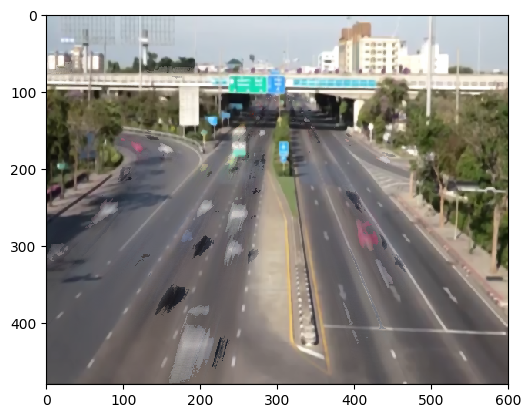

In [17]:
# for (i, frame) in enumerate(reader[:iter_data]())
for (i, frame) in enumerate(frames)
#     if i > 100
#         break
#     end
    
#     frame = T.preprocess_frame(frame);
    foreground = T.subtract_background(frame, background, 0.1);

#    foreground = T.suppress_shadows(frame, background, foreground, 0.6, 0.6, 0.3, 0.7);
#     vehicle_boxes = T.foreground_bounding_boxes(foreground);

#     writeVideo(writer, img);

    background = T.update_background(frame, background, foreground, 0.95);
end

imshow(background);

In [357]:
module StMrf

import Tracking
using PyCall

@pyimport skimage.feature as feature

const D_ROWS = [0 1 1 1 0 -1 -1 -1 0]
const D_COLS = [-1 -1 0 1 1 1 0 -1 0]

type Block
    start_x::Int;
    start_y::Int;
    end_x::Int;
    end_y::Int;
    object_id::Int;
    x_inds::Function;
    y_inds::Function;
    coords::Function;
    
    function Block(start_x::Int, start_y::Int, width::Int, height::Int)
        this = new(start_x, start_y, start_x + width, start_y + height, 0);
        
        this.x_inds = function() 
            return this.start_x:this.end_x
        end
        
        this.y_inds = function() 
            return this.start_y:this.end_y
        end
        
        this.coords = function(displacement::Union{Array{Int, 1}, Tuple{Int, Int}} = (0, 0)) 
            return (this.y_inds() .+ displacement[1], this.x_inds() .+ displacement[2])
        end
        
        return this
    end
end

function blocks_to_object_map(blocks::Array{Block, 2})
    end_x = blocks[1, end].end_x
    end_y = blocks[end, 1].end_y
    
    frame = zeros(Int, end_y, end_x)
    for block in blocks
        frame[block.coords()...] = block.object_id
    end
    
    return frame
end

function is_foreground(block::Block, frame::Tracking.Img3Type, background::Tracking.Img3Type, threshold::Float64)
    y_inds = block.start_y:block.end_y
    x_inds = block.start_x:block.end_x
    
    return mean(abs.(frame[y_inds, x_inds, :] - background[y_inds, x_inds, :])) > threshold
end

function get_block(blocks::Array{Block, 2}, x::Int, y::Int, block_width::Int, block_height::Int)
    return blocks[floor(Int, y / block_height), floor(Int, x / block_width)]
end

function update_slit_objects!(slit_line::Array{Block, 1}, frame::Tracking.Img3Type, background::Tracking.Img3Type, 
                              new_block_id::Int; threshold::Float64=0.1)
    new_block_id = copy(new_block_id) - 1;
    has_new = false;
    obj_ids = zeros(Int, size(slit_line, 1));
    obj_ids_old = [b.object_id for b in slit_line];

    for (id, block) in enumerate(slit_line)
        if is_foreground(block, frame, background, threshold)
            if !has_new
                new_block_id += 1
            end

            obj_ids[id] = new_block_id
            has_new = true
        else
            has_new = false
        end
    end
    
    for id in unique(obj_ids[obj_ids .> 0])
        old_ids = unique(obj_ids_old[obj_ids .== id])
        old_ids = old_ids[old_ids .> 0]
        if size(old_ids, 1) > 0
            obj_ids[obj_ids .== id] = old_ids[1]
        end
    end
    
    for (b, id) in zip(slit_line, obj_ids)
        b.object_id = id
    end
    
    return maximum(obj_ids) + 1
end

function motion_vector_diffs(blocks, frame, old_frame, coords)
    function get_diff(old_block_coords, new_block_coords)
        new_coords = blocks[new_block_coords...].coords();
        old_coords = blocks[old_block_coords...].coords();
        return sum(abs.(frame[new_coords...] .- old_frame[old_coords...]))
    end
    

    diffs = Array{Float64, 1}();
    for dc in zip(D_ROWS, D_COLS)
        cur_coords = coords .+ dc
        if any(cur_coords .< 1) || any(cur_coords .> size(blocks))
            cur_diff = 1e5
        else
            cur_diff = get_diff(coords, cur_coords)
        end
        push!(diffs, cur_diff)
    end
    
    return collect(zip(D_ROWS, D_COLS)), diffs
end

function motion_vector_similarity_map(blocks, frame, old_frame, coords::Tuple{Int, Int}; search_rad::Int=1)
    x_coords = blocks[coords[1], coords[2] - search_rad].start_x:blocks[coords[1], coords[2] + search_rad].end_x;
    y_coords = blocks[coords[1] - search_rad, coords[2]].start_y:blocks[coords[1], coords[2] + search_rad].end_y;

    cur_img_block = frame[blocks[coords...].y_inds(), blocks[coords...].x_inds(),:];
    match_img_region = old_frame[y_coords, x_coords, :];

    sim_map = feature.match_template(match_img_region, cur_img_block)[:,:,1];
    return sim_map
end

function find_motion_vector(blocks, frame, old_frame, group_coords::Array{Tuple{Int, Int}, 1}; search_rad::Int=1)
    vec_diffs = [motion_vector_similarity_map(blocks, frame, old_frame, c, search_rad=search_rad) for c in group_coords];
    sim_map = reduce(+, vec_diffs);
    return vcat(findn(sim_map .== maximum(sim_map))...)
end

function update_object_ids(blocks, block_id_map::Array{Int, 2}, motion_vecs::Union{Array{Tuple{Int, Int}, 1}, Array{Array{Int, 1}, 1}}, 
                           group_coords::Array{Array{Tuple{Int64,Int64},1},1}, frame, background; 
                           threshold::Float64=0.2)
    new_block_id_map = hcat([[Set{Int}() for _ in 1:size(block_id_map, 1)] for _ in 1:size(block_id_map, 2)]...)
    for (gc, m_vec) in zip(group_coords, motion_vecs)
        for coords in gc
            new_coords = coords .+ m_vec

            if !is_foreground(blocks[new_coords...], frame, background, threshold)
                continue
            end

            cur_block_id = block_id_map[coords...];
            push!(new_block_id_map[new_coords...], cur_block_id)

            for dc in zip(D_ROWS[1:end-1], D_COLS[1:end-1])
                cur_coords = new_coords .+ dc
                if any(cur_coords .< 1) || any(cur_coords .> size(blocks))
                    continue
                end

                if cur_block_id in new_block_id_map[cur_coords...]
                    continue
                end

                if is_foreground(blocks[cur_coords...], frame, background, threshold)
                    push!(new_block_id_map[cur_coords...], cur_block_id)
                end
            end
        end
    end
    
    return new_block_id_map;
end

end

import StMrf
SM = StMrf;

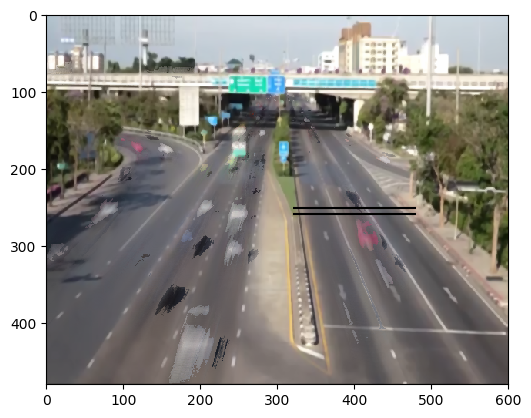

In [358]:
# slit_x = 285;
# slit_y = 200;
# slit_width = 80;
slit_x = 320;
slit_y = 250;
slit_width = 160;

block_width = 10;
block_height = 8;

imshow(background)
PyPlot.hlines(slit_y, xmin=slit_x, xmax=slit_x + slit_width)
PyPlot.hlines(slit_y + block_height, xmin=slit_x, xmax=slit_x + slit_width);

In [359]:
module Tm

import StMrf
import PyPlot

function plot_frame(frame, slit_x, slit_y, slit_width, block_height)
    PyPlot.imshow(frame)
    PyPlot.hlines(slit_y, xmin=slit_x, xmax=slit_x + slit_width)
    PyPlot.hlines(slit_y + block_height, xmin=slit_x, xmax=slit_x + slit_width);
end

end
import Tm

In [360]:
threshold = 0.05

0.05

1-element Array{Int64,1}:
 0

In [361]:
blocks = Array{SM.Block, 2}(floor(Int, size(background, 1) / block_height) - 1, floor(Int, size(background, 2) / block_width) - 1)
for row_id in 1:size(blocks, 1)
    const row_start = row_id * block_height;
    for col_id in 1:size(blocks, 2)
        const col_start = col_id * block_width;
        blocks[row_id, col_id] = SM.Block(col_start, row_start, block_width, block_height);
    end
end

slit_line = [SM.get_block(blocks, slit_x + i * block_width, slit_y, block_width, block_height) for i in 1:floor(Int, slit_width / block_width)];

new_object_id = 1;
f_id = 291;

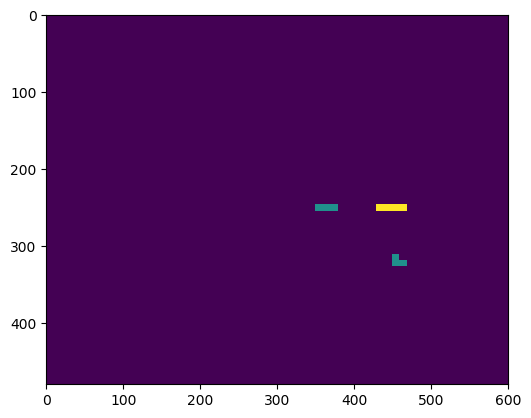

PyObject <matplotlib.image.AxesImage object at 0x7f3c04a3bc18>

In [356]:
imshow(SM.blocks_to_object_map(blocks))

Array{Int64,1}[[9, 11], [8, 10]]
Array{Int64,1}[[8, 11], [9, 11], [8, 10]]
Array{Int64,1}[[8, 10], [9, 11], [8, 10]]
Array{Int64,1}[[8, 11], [9, 11], [8, 10], [9, 11]]
Array{Int64,1}[[8, 10], [9, 11], [8, 10]]
Array{Int64,1}[[8, 10], [9, 11], [8, 10]]
Array{Int64,1}[[8, 10], [9, 11], [8, 10]]
Array{Int64,1}[[8, 11], [9, 11], [8, 10]]


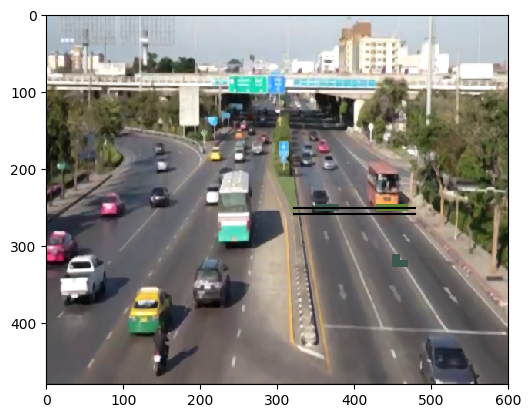

Array{Int64,1}[[8, 10], [9, 11], [8, 10]]
Array{Int64,1}[[8, 10], [9, 11], [8, 10]]


In [355]:
frame = frames[f_id];
for i in 1:10
    frame = frames[f_id];
    last_id = SM.update_slit_objects!(slit_line, frame, background, new_object_id; threshold=threshold);
    new_object_id = max(new_object_id, last_id)
    
    old_frame = frame;
    frame = frames[f_id + 1];

    obj_ids_map = map(b -> b.object_id, blocks);

    block_ids = unique(obj_ids_map);
    block_ids = block_ids[block_ids .> 0]
    group_coords = [collect(zip(findn(obj_ids_map .== id)...)) for id in block_ids]
#     vec_diffs = [[SM.motion_vector_diffs(blocks, frame, old_frame, coords) for coords in gc] for gc in group_coords]
#     motion_vecs = [diffs[1][1][findmin(sum(hcat([v[2] for v in diffs]...), 2))[2]] for diffs in vec_diffs];
    motion_vecs = [SM.find_motion_vector(blocks, frame, old_frame, gc) for gc in group_coords]
    println(motion_vecs)
    
    if size(motion_vecs, 1) == 0
        f_id += 1
        continue
    end

    new_map = SM.update_object_ids(blocks, obj_ids_map, motion_vecs, group_coords, frame, background; 
                                   threshold=threshold);
    new_map[map(x -> x.start_y, blocks) .< slit_y] = Set();

    for (b, ids) in zip(blocks, new_map)
        if length(ids) == 0
            b.object_id = 0
            continue
        end
        b.object_id = collect(ids)[1]
    end

    SM.update_slit_objects!(slit_line, frame, background, 1);
    f_id += 1
#     @show maximum(map(length, new_map))
end

plot_frame = deepcopy(frame);
for b in blocks
    if b.object_id == 0
        continue
    end

    srand(b.object_id)

    plot_frame[b.y_inds(), b.x_inds(),1] .= rand()
    plot_frame[b.y_inds(), b.x_inds(),2] .= rand()
    plot_frame[b.y_inds(), b.x_inds(),3] .= rand()
end

Tm.plot_frame(plot_frame, slit_x, slit_y, slit_width, block_height);

$U_N(N_{y_k})$: Pott's J = -$\alpha$;  
$D_{xy_k}$: difference between a block in the previous frame and displaced block in the current frame;  


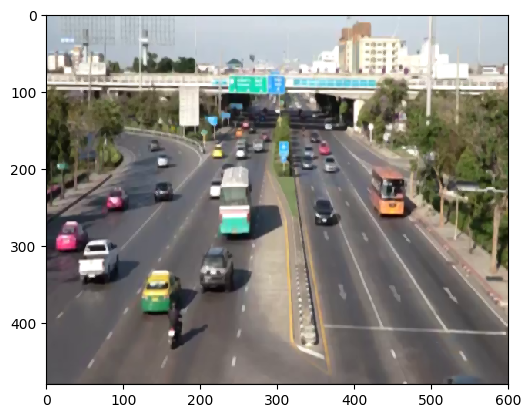

PyObject <matplotlib.image.AxesImage object at 0x7f3c1859fdd8>

In [36]:
imshow(frame)

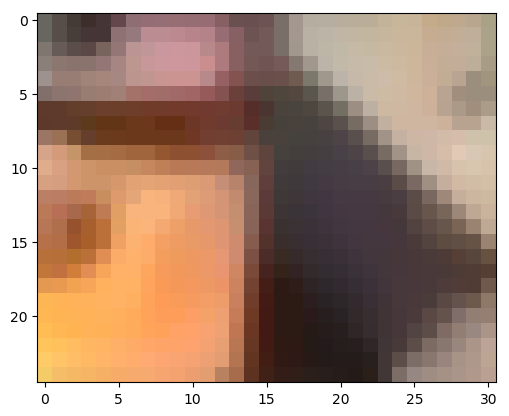

In [143]:
block_id_x = 45;
block_id_y = 29;

x_coords = blocks[block_id_y, block_id_x].start_x:blocks[block_id_y, block_id_x + 2].end_x;
y_coords = blocks[block_id_y, block_id_x].start_y:blocks[block_id_y + 2, block_id_x].end_y;
imshow(frames[f_id - 2][y_coords, x_coords,:]);
# y_coords, x_coords

In [59]:
@pyimport skimage.feature as feature

In [256]:
obj_ids_map = map(b -> b.object_id, blocks);

block_ids = unique(obj_ids_map);
block_ids = block_ids[block_ids .> 0]
group_coords = [collect(zip(findn(obj_ids_map .== id)...)) for id in block_ids];
coords = group_coords[2][1]

(34, 35)

In [310]:
vec_diffs = [SM.motion_vector_similarity_map(blocks, frame, old_frame, coords) for coords in group_coords[3]];

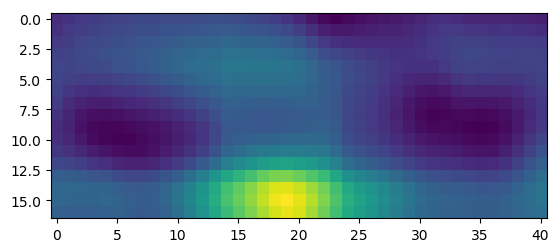

PyObject <matplotlib.image.AxesImage object at 0x7f3c051e8d30>

In [312]:
imshow(reduce(+, vec_diffs))

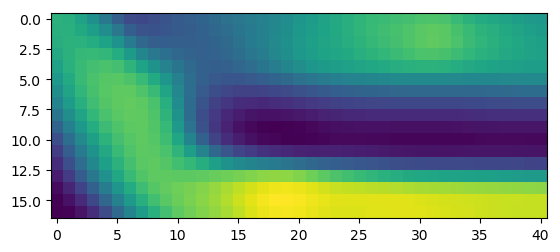

PyObject <matplotlib.image.AxesImage object at 0x7f3c04d4ec88>

In [308]:
imshow(vec_diffs[5])

In [257]:
old_frame = frames[f_id - 1];

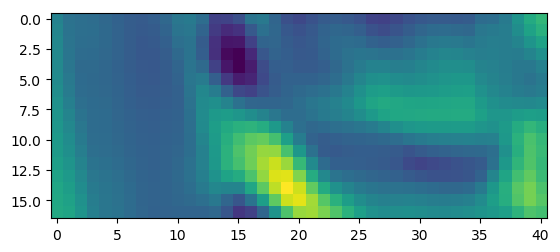

PyObject <matplotlib.image.AxesImage object at 0x7f3c0529bb70>

In [262]:
imshow(sim_map)